In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from skimage.color import rgba2rgb

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data_con.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291 entries, 0 to 2290
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  2291 non-null   int64 
 1   link          2291 non-null   object
 2   main          2291 non-null   object
 3   dec           2291 non-null   object
 4   price         2291 non-null   object
 5   marka         2291 non-null   object
 6   target        2291 non-null   int64 
 7   a             2291 non-null   int64 
 8   d             2291 non-null   int64 
 9   o             2291 non-null   int64 
 10  k             2291 non-null   int64 
 11  e             2291 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 232.7+ KB


In [4]:
X = np.load('mod.npy')

In [5]:
X.shape

(2291, 128, 128, 3)

In [6]:
mobil_net=tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,pooling='max',
    weights='imagenet',input_shape=(128,128,3)
)
mobil_net.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        
        
        tf.keras.layers.Dense(3,activation='softmax')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="categorical_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model

model=model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
df_ = df[df.a == 1]

In [9]:
df_.target.value_counts()

0    450
2    427
1    399
Name: target, dtype: int64

In [10]:
df_ = pd.concat([df_[df_.target == 0].sample(399), df_[df_.target == 2].sample(399), df_[df_.target == 1]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 628 to 1528
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  1197 non-null   int64 
 1   link          1197 non-null   object
 2   main          1197 non-null   object
 3   dec           1197 non-null   object
 4   price         1197 non-null   object
 5   marka         1197 non-null   object
 6   target        1197 non-null   int64 
 7   a             1197 non-null   int64 
 8   d             1197 non-null   int64 
 9   o             1197 non-null   int64 
 10  k             1197 non-null   int64 
 11  e             1197 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 121.6+ KB


In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [12]:
co = OneHotEncoder()
co.fit(df_[['target']])
y = co.transform(df_[['target']])
y = y.toarray()

In [13]:
x = X[df_.index]

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [15]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10, batch_size=32,
    
)

Epoch 1/10
27/27 [==============================] - 21s 676ms/step - loss: 2.1013 - accuracy: 0.3548 - val_loss: 1.5233 - val_accuracy: 0.4361
Epoch 2/10
27/27 [==============================] - 13s 478ms/step - loss: 1.3599 - accuracy: 0.4982 - val_loss: 1.3420 - val_accuracy: 0.4722
Epoch 3/10
27/27 [==============================] - 12s 448ms/step - loss: 1.0812 - accuracy: 0.5496 - val_loss: 1.3105 - val_accuracy: 0.4889
Epoch 4/10
27/27 [==============================] - 18s 697ms/step - loss: 0.9284 - accuracy: 0.5926 - val_loss: 1.2798 - val_accuracy: 0.4917
Epoch 5/10
27/27 [==============================] - 13s 497ms/step - loss: 0.8114 - accuracy: 0.6440 - val_loss: 1.2353 - val_accuracy: 0.5056
Epoch 6/10
27/27 [==============================] - 15s 547ms/step - loss: 0.7253 - accuracy: 0.7025 - val_loss: 1.2305 - val_accuracy: 0.5306
Epoch 7/10
27/27 [==============================] - 13s 472ms/step - loss: 0.6373 - accuracy: 0.7431 - val_loss: 1.2359 - val_accuracy: 0.5222

In [16]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100, batch_size=32, verbose=-1, callbacks=tf.keras.callbacks.EarlyStopping(patience=3)
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100


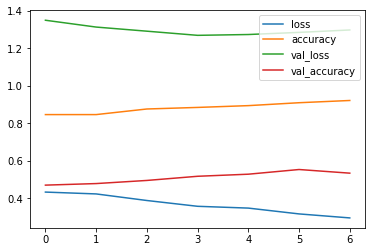

In [40]:
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')


In [43]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dense(1000,activation="relu"),
        tf.keras.layers.Dense(512,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(3,activation='softmax')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="categorical_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model

model=model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              1281000   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 4,117,547
Trainable params: 1,859,563
Non-trainable params: 2,257,984
____________________________________

In [44]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=32,callbacks=tf.keras.callbacks.EarlyStopping(patience=7)
    
)

Epoch 1/20
27/27 [==============================] - 23s 660ms/step - loss: 1.9434 - accuracy: 0.3608 - val_loss: 1.0837 - val_accuracy: 0.3833
Epoch 2/20
27/27 [==============================] - 12s 465ms/step - loss: 1.0783 - accuracy: 0.3919 - val_loss: 1.0316 - val_accuracy: 0.4639
Epoch 3/20
27/27 [==============================] - 12s 467ms/step - loss: 1.0009 - accuracy: 0.4863 - val_loss: 0.9872 - val_accuracy: 0.5111
Epoch 4/20
27/27 [==============================] - 13s 474ms/step - loss: 0.9699 - accuracy: 0.5054 - val_loss: 1.0085 - val_accuracy: 0.4361
Epoch 5/20
27/27 [==============================] - 13s 473ms/step - loss: 0.9212 - accuracy: 0.5460 - val_loss: 1.1008 - val_accuracy: 0.4944
Epoch 6/20
27/27 [==============================] - 15s 546ms/step - loss: 0.8528 - accuracy: 0.5998 - val_loss: 0.9195 - val_accuracy: 0.5778
Epoch 7/20
27/27 [==============================] - 14s 510ms/step - loss: 0.7705 - accuracy: 0.6679 - val_loss: 0.9610 - val_accuracy: 0.5444

In [46]:
#model for classifying phones
model.save('model.h5')

In [47]:
y_pred = model.predict_classes(x_test)

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [48]:
y_actual = np.argmax(y_test,1)

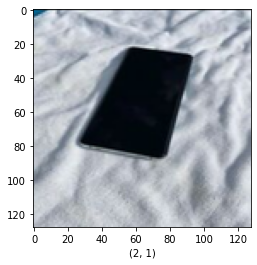

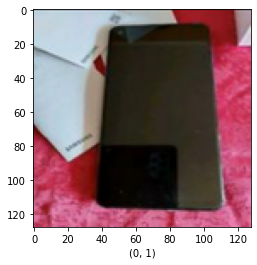

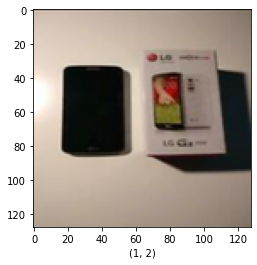

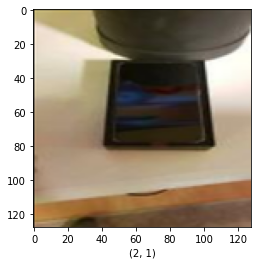

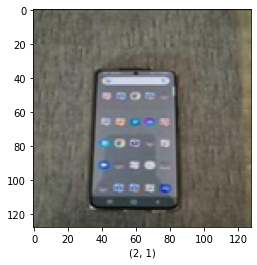

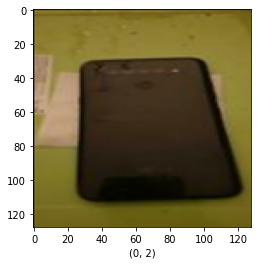

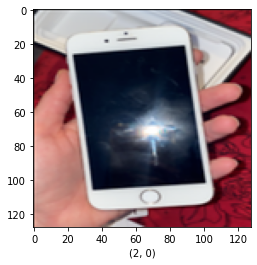

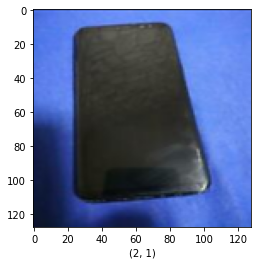

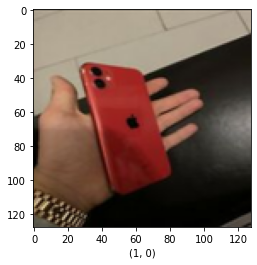

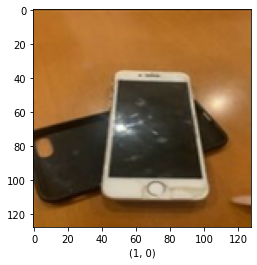

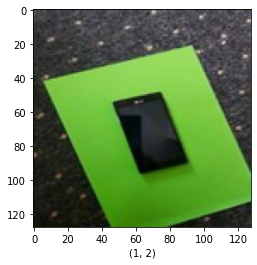

In [49]:
for i in range(len(y_pred)):
    if y_pred[i] != y_actual[i]:
        plt.imshow(x_test[i])
        plt.xlabel(f'{y_pred[i], y_actual[i]}')
        plt.show()
    if i == 20:
        break

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
confusion_matrix(y_actual, y_pred)

array([[58, 29, 41],
       [14, 54, 42],
       [11, 25, 86]])

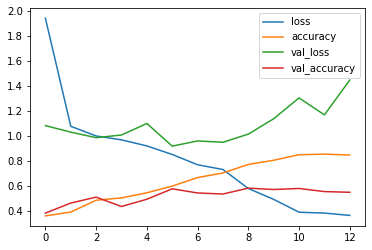

In [62]:
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')




In [52]:
from keras.preprocessing.image import ImageDataGenerator

In [53]:
model= model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1281000   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 387       
Total params: 4,117,547
Trainable params: 1,859,563
Non-trainable params: 2,257,984
____________________________________

In [55]:
datagen = ImageDataGenerator(
     rotation_range=45,
        shear_range=0.3,
        zoom_range=0.3,
       vertical_flip=True)

In [56]:
datagen.fit(x_train)

In [57]:
for e in range(100):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch, verbose=-1)
        batches += 1
        if batches >= len(x_train) / 32:
            break

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [58]:
y_pred = model.predict_classes(x_test)

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [59]:
y_actual = np.argmax(y_test,1)

In [60]:
confusion_matrix(y_actual,y_pred)

array([[71, 38, 19],
       [15, 76, 19],
       [16, 46, 60]])

In [63]:
x_test.shape

(360, 128, 128, 3)

In [64]:
df_ = df[df.a == 1]
df_ = pd.concat([df_[df_.target == 0].sample(399), df_[df_.target == 1]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 224 to 1528
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  798 non-null    int64 
 1   link          798 non-null    object
 2   main          798 non-null    object
 3   dec           798 non-null    object
 4   price         798 non-null    object
 5   marka         798 non-null    object
 6   target        798 non-null    int64 
 7   a             798 non-null    int64 
 8   d             798 non-null    int64 
 9   o             798 non-null    int64 
 10  k             798 non-null    int64 
 11  e             798 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 81.0+ KB


In [65]:
x = X[df_.index]
y = df_['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [75]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [76]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, batch_size=32, callbacks=tf.keras.callbacks.EarlyStopping(patience=10,monitor='accuracy'),
    verbose=0
    
)

<Figure size 864x864 with 0 Axes>

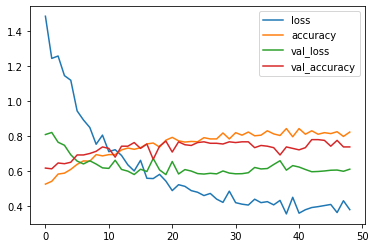

In [78]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [79]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dense(1000,activation="relu"),
        tf.keras.layers.Dense(512,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              1281000   
_________________________________________________________________
dense_17 (Dense)             (None, 512)               512512    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 4,117,289
Trainable params: 1,859,305
Non-trainable params: 2,257,984
____________________________________

In [80]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, batch_size=32, callbacks=tf.keras.callbacks.EarlyStopping(patience=10,monitor='accuracy'),
    verbose=0
    
)

<Figure size 864x864 with 0 Axes>

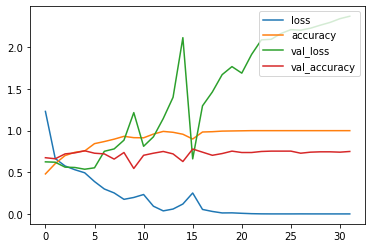

In [81]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [82]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dense(100,activation="relu"),
         tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dropout(0.7),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_20 (Dense)             (None, 100)               128100    
_________________________________________________________________
dense_21 (Dense)             (None, 32)                3232      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 2,389,349
Trainable params: 131,365
Non-trainable params: 2,257,984
_________________________________________________________________


In [83]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=32,callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='accuracy')
    
)

Epoch 1/30
18/18 [==============================] - 14s 556ms/step - loss: 1.0597 - accuracy: 0.5287 - val_loss: 0.7585 - val_accuracy: 0.4792
Epoch 2/30
18/18 [==============================] - 9s 505ms/step - loss: 0.7412 - accuracy: 0.5108 - val_loss: 0.6845 - val_accuracy: 0.5583
Epoch 3/30
18/18 [==============================] - 9s 522ms/step - loss: 0.6825 - accuracy: 0.5556 - val_loss: 0.6744 - val_accuracy: 0.6208
Epoch 4/30
18/18 [==============================] - 9s 524ms/step - loss: 0.6688 - accuracy: 0.5681 - val_loss: 0.6463 - val_accuracy: 0.6167
Epoch 5/30
18/18 [==============================] - 11s 608ms/step - loss: 0.6395 - accuracy: 0.5789 - val_loss: 0.6478 - val_accuracy: 0.6208
Epoch 6/30
18/18 [==============================] - 13s 743ms/step - loss: 0.6296 - accuracy: 0.5968 - val_loss: 0.6333 - val_accuracy: 0.6375
Epoch 7/30
18/18 [==============================] - 9s 527ms/step - loss: 0.6235 - accuracy: 0.6129 - val_loss: 0.6400 - val_accuracy: 0.6292
Epo

<Figure size 864x864 with 0 Axes>

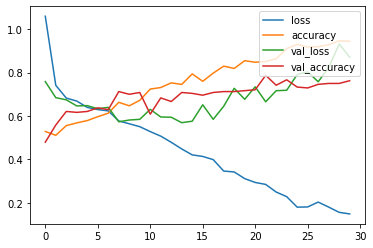

In [84]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [85]:
y_pred = model.predict_classes(x_test)

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [86]:
confusion_matrix(y_test, y_pred)

array([[102,  23],
       [ 34,  81]])

In [87]:
#model for classifying phones
model.save('model2.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [88]:
df_ = pd.concat([df[(df.e == 0) & (df.a == 1)].sample(50), df[df.o == 1]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 866 to 2289
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  100 non-null    int64 
 1   link          100 non-null    object
 2   main          100 non-null    object
 3   dec           100 non-null    object
 4   price         100 non-null    object
 5   marka         100 non-null    object
 6   target        100 non-null    int64 
 7   a             100 non-null    int64 
 8   d             100 non-null    int64 
 9   o             100 non-null    int64 
 10  k             100 non-null    int64 
 11  e             100 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 10.2+ KB


In [89]:
x = X[df_.index]
y = df_['a']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [90]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [108]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [109]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=32,callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
    
)

Epoch 1/30
3/3 [==============================] - 4s 728ms/step - loss: 0.7059 - accuracy: 0.4850 - val_loss: 0.6921 - val_accuracy: 0.4333
Epoch 2/30
3/3 [==============================] - 1s 328ms/step - loss: 0.6954 - accuracy: 0.4954 - val_loss: 0.7164 - val_accuracy: 0.4333
Epoch 3/30
3/3 [==============================] - 1s 350ms/step - loss: 0.7423 - accuracy: 0.5403 - val_loss: 0.6924 - val_accuracy: 0.4333
Epoch 4/30
3/3 [==============================] - 1s 332ms/step - loss: 0.6768 - accuracy: 0.5936 - val_loss: 0.7110 - val_accuracy: 0.4333
Epoch 5/30
3/3 [==============================] - 1s 326ms/step - loss: 0.6627 - accuracy: 0.5592 - val_loss: 0.6850 - val_accuracy: 0.4667
Epoch 6/30
3/3 [==============================] - 1s 326ms/step - loss: 0.6703 - accuracy: 0.6112 - val_loss: 0.6830 - val_accuracy: 0.4667
Epoch 7/30
3/3 [==============================] - 1s 331ms/step - loss: 0.6644 - accuracy: 0.5709 - val_loss: 0.6702 - val_accuracy: 0.4667
Epoch 8/30
3/3 [====

<Figure size 864x864 with 0 Axes>

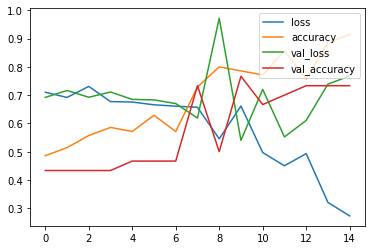

In [110]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [112]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [113]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=32,callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
    
)

Epoch 1/30
3/3 [==============================] - 5s 794ms/step - loss: 1.5403 - accuracy: 0.5571 - val_loss: 0.6517 - val_accuracy: 0.6667
Epoch 2/30
3/3 [==============================] - 1s 350ms/step - loss: 1.1554 - accuracy: 0.5429 - val_loss: 0.5653 - val_accuracy: 0.7000
Epoch 3/30
3/3 [==============================] - 1s 356ms/step - loss: 0.8585 - accuracy: 0.6429 - val_loss: 0.4041 - val_accuracy: 0.7667
Epoch 4/30
3/3 [==============================] - 1s 355ms/step - loss: 0.8679 - accuracy: 0.6571 - val_loss: 0.3528 - val_accuracy: 0.8667
Epoch 5/30
3/3 [==============================] - 1s 360ms/step - loss: 0.6771 - accuracy: 0.7429 - val_loss: 0.3349 - val_accuracy: 0.8667
Epoch 6/30
3/3 [==============================] - 1s 353ms/step - loss: 0.7773 - accuracy: 0.7143 - val_loss: 0.3199 - val_accuracy: 0.8333
Epoch 7/30
3/3 [==============================] - 1s 352ms/step - loss: 0.7818 - accuracy: 0.7286 - val_loss: 0.3376 - val_accuracy: 0.8000
Epoch 8/30
3/3 [====

<Figure size 864x864 with 0 Axes>

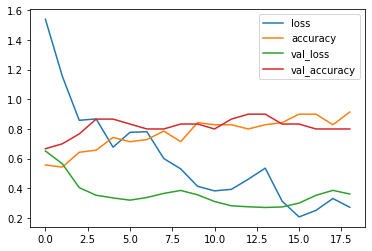

In [114]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [115]:
#model for classifying phones with or without touchscreen
model.save('mod_tas.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [116]:
df_ = pd.concat([df[(df.e == 0) & (df.a == 1)].sample(343), df[df.e == 1]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 1925 to 2217
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  686 non-null    int64 
 1   link          686 non-null    object
 2   main          686 non-null    object
 3   dec           686 non-null    object
 4   price         686 non-null    object
 5   marka         686 non-null    object
 6   target        686 non-null    int64 
 7   a             686 non-null    int64 
 8   d             686 non-null    int64 
 9   o             686 non-null    int64 
 10  k             686 non-null    int64 
 11  e             686 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 69.7+ KB


In [117]:
x = X[df_.index]
y = df_['a']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [118]:
model=model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [119]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
    
)

Epoch 1/30
48/48 [==============================] - 14s 178ms/step - loss: 1.1349 - accuracy: 0.6438 - val_loss: 0.6040 - val_accuracy: 0.7816
Epoch 2/30
48/48 [==============================] - 8s 157ms/step - loss: 0.7770 - accuracy: 0.7563 - val_loss: 0.4509 - val_accuracy: 0.8398
Epoch 3/30
48/48 [==============================] - 8s 160ms/step - loss: 0.7843 - accuracy: 0.7688 - val_loss: 0.4376 - val_accuracy: 0.8544
Epoch 4/30
48/48 [==============================] - 8s 163ms/step - loss: 0.7160 - accuracy: 0.7896 - val_loss: 0.3750 - val_accuracy: 0.8689
Epoch 5/30
48/48 [==============================] - 8s 176ms/step - loss: 0.5068 - accuracy: 0.8354 - val_loss: 0.3773 - val_accuracy: 0.8689
Epoch 6/30
48/48 [==============================] - 8s 166ms/step - loss: 0.5818 - accuracy: 0.8229 - val_loss: 0.3849 - val_accuracy: 0.8641
Epoch 7/30
48/48 [==============================] - 8s 167ms/step - loss: 0.4636 - accuracy: 0.8500 - val_loss: 0.3968 - val_accuracy: 0.8641
Epoch

In [120]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dense(200,activation="relu"),
         tf.keras.layers.Dense(100,activation="relu"),
        tf.keras.layers.Dense(50,activation="relu"),
         tf.keras.layers.Dense(32,activation="relu"),
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_25 (Dense)             (None, 200)               256200    
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)               

In [121]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10, batch_size=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
    
)

Epoch 1/10
48/48 [==============================] - 12s 188ms/step - loss: 0.6694 - accuracy: 0.7063 - val_loss: 0.4298 - val_accuracy: 0.7864
Epoch 2/10
48/48 [==============================] - 8s 160ms/step - loss: 0.4698 - accuracy: 0.7937 - val_loss: 0.3796 - val_accuracy: 0.8592
Epoch 3/10
48/48 [==============================] - 8s 161ms/step - loss: 0.3962 - accuracy: 0.8458 - val_loss: 0.3329 - val_accuracy: 0.8641
Epoch 4/10
48/48 [==============================] - 8s 160ms/step - loss: 0.2676 - accuracy: 0.9000 - val_loss: 0.2878 - val_accuracy: 0.8932
Epoch 5/10
48/48 [==============================] - 8s 171ms/step - loss: 0.2160 - accuracy: 0.9062 - val_loss: 0.2844 - val_accuracy: 0.8786
Epoch 6/10
48/48 [==============================] - 8s 160ms/step - loss: 0.1881 - accuracy: 0.9417 - val_loss: 0.3802 - val_accuracy: 0.8544
Epoch 7/10
48/48 [==============================] - 8s 171ms/step - loss: 0.1132 - accuracy: 0.9646 - val_loss: 0.5156 - val_accuracy: 0.8641
Epoch

<Figure size 864x864 with 0 Axes>

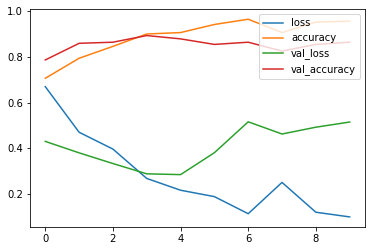

In [129]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [122]:
#model for classifying wheter there is  a handy or not
model.save('mod_hand.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [123]:
df[df.k == 1].marka.value_counts()

samsung    107
apple       72
lg          12
htc          8
nokia        2
Name: marka, dtype: int64

In [124]:
df_ = pd.concat([df[(df.k == 1)  &(df.marka == 'samsung')].sample(72), 
                df[(df.k == 1)  &(df.marka == 'apple')]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 1461 to 749
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  144 non-null    int64 
 1   link          144 non-null    object
 2   main          144 non-null    object
 3   dec           144 non-null    object
 4   price         144 non-null    object
 5   marka         144 non-null    object
 6   target        144 non-null    int64 
 7   a             144 non-null    int64 
 8   d             144 non-null    int64 
 9   o             144 non-null    int64 
 10  k             144 non-null    int64 
 11  e             144 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 14.6+ KB


In [127]:
df_.target.value_counts()

1    72
0    72
Name: target, dtype: int64

In [128]:
x = X[df_.index]
y = df_['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [130]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [131]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='accuracy')
    
)

Epoch 1/30
12/12 [==============================] - 5s 224ms/step - loss: 1.7480 - accuracy: 0.5826 - val_loss: 0.5138 - val_accuracy: 0.7241
Epoch 2/30
12/12 [==============================] - 2s 147ms/step - loss: 0.8471 - accuracy: 0.7391 - val_loss: 0.3454 - val_accuracy: 0.8621
Epoch 3/30
12/12 [==============================] - 2s 146ms/step - loss: 0.6635 - accuracy: 0.7391 - val_loss: 0.4540 - val_accuracy: 0.8276
Epoch 4/30
12/12 [==============================] - 2s 175ms/step - loss: 0.6022 - accuracy: 0.8174 - val_loss: 0.2219 - val_accuracy: 0.8966
Epoch 5/30
12/12 [==============================] - 2s 173ms/step - loss: 0.3596 - accuracy: 0.8261 - val_loss: 0.2553 - val_accuracy: 0.8621
Epoch 6/30
12/12 [==============================] - 2s 148ms/step - loss: 0.5211 - accuracy: 0.7913 - val_loss: 0.1942 - val_accuracy: 0.8966
Epoch 7/30
12/12 [==============================] - 2s 170ms/step - loss: 0.3320 - accuracy: 0.8957 - val_loss: 0.2523 - val_accuracy: 0.8966
Epoch 

<Figure size 864x864 with 0 Axes>

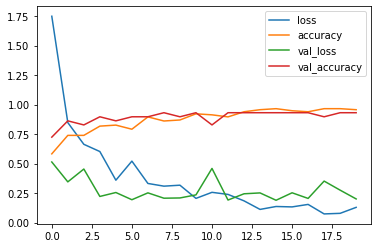

In [132]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [133]:
#model for classifying boxes 
model.save('mod_box.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [135]:
df_ = pd.concat([df[(df.e == 1)].sample(201), 
                df[(df.k == 1)]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 1119 to 2132
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  402 non-null    int64 
 1   link          402 non-null    object
 2   main          402 non-null    object
 3   dec           402 non-null    object
 4   price         402 non-null    object
 5   marka         402 non-null    object
 6   target        402 non-null    int64 
 7   a             402 non-null    int64 
 8   d             402 non-null    int64 
 9   o             402 non-null    int64 
 10  k             402 non-null    int64 
 11  e             402 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 40.8+ KB


In [136]:
x = X[df_.index]
y = df_['k']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [137]:
def model():
    model=tf.keras.models.Sequential([
        mobil_net,
        tf.keras.layers.Dropout(0.5),
        
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    
    ])
    model.layers[0].trainable=False
    model.compile(loss="binary_crossentropy",optimizer='adam',
                  metrics=['accuracy'])
    return model
model=model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [138]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=5,monitor='accuracy')
    
)

Epoch 1/30
33/33 [==============================] - 9s 176ms/step - loss: 1.3550 - accuracy: 0.6106 - val_loss: 0.5511 - val_accuracy: 0.7531
Epoch 2/30
33/33 [==============================] - 5s 143ms/step - loss: 0.9574 - accuracy: 0.6885 - val_loss: 0.5429 - val_accuracy: 0.7901
Epoch 3/30
33/33 [==============================] - 5s 143ms/step - loss: 0.7049 - accuracy: 0.7695 - val_loss: 0.5137 - val_accuracy: 0.8025
Epoch 4/30
33/33 [==============================] - 5s 151ms/step - loss: 0.7323 - accuracy: 0.7913 - val_loss: 0.4116 - val_accuracy: 0.8395
Epoch 5/30
33/33 [==============================] - 5s 156ms/step - loss: 0.6656 - accuracy: 0.7850 - val_loss: 0.3934 - val_accuracy: 0.8395
Epoch 6/30
33/33 [==============================] - 5s 160ms/step - loss: 0.4795 - accuracy: 0.8255 - val_loss: 0.3726 - val_accuracy: 0.8519
Epoch 7/30
33/33 [==============================] - 5s 148ms/step - loss: 0.4369 - accuracy: 0.8411 - val_loss: 0.3713 - val_accuracy: 0.8272
Epoch 

In [139]:
#model for classifying wheter there is  a box or not
model.save('mod_box_not.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [142]:
df_ = pd.concat([df[(df.a == 1)].sample(201), 
                df[df.k == 1]])
index = df_.index
df_.reset_index().drop(['index'], 1, inplace= True)
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 134 to 2132
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  402 non-null    int64 
 1   link          402 non-null    object
 2   main          402 non-null    object
 3   dec           402 non-null    object
 4   price         402 non-null    object
 5   marka         402 non-null    object
 6   target        402 non-null    int64 
 7   a             402 non-null    int64 
 8   d             402 non-null    int64 
 9   o             402 non-null    int64 
 10  k             402 non-null    int64 
 11  e             402 non-null    int64 
dtypes: int64(7), object(5)
memory usage: 40.8+ KB


In [147]:
x = X[df_.index]
y = df_['k']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [148]:
model= model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [149]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30, batch_size=10, callbacks=tf.keras.callbacks.EarlyStopping(patience=7,monitor='accuracy')
    
)

Epoch 1/30
33/33 [==============================] - 15s 178ms/step - loss: 1.4030 - accuracy: 0.5607 - val_loss: 0.7649 - val_accuracy: 0.6543
Epoch 2/30
33/33 [==============================] - 5s 163ms/step - loss: 0.9799 - accuracy: 0.7009 - val_loss: 0.5110 - val_accuracy: 0.7901
Epoch 3/30
33/33 [==============================] - 5s 164ms/step - loss: 0.7143 - accuracy: 0.7632 - val_loss: 0.4469 - val_accuracy: 0.8395
Epoch 4/30
33/33 [==============================] - 5s 150ms/step - loss: 0.5818 - accuracy: 0.7882 - val_loss: 0.4341 - val_accuracy: 0.8148
Epoch 5/30
33/33 [==============================] - 5s 167ms/step - loss: 0.5928 - accuracy: 0.8006 - val_loss: 0.4117 - val_accuracy: 0.8272
Epoch 6/30
33/33 [==============================] - 6s 190ms/step - loss: 0.4167 - accuracy: 0.8380 - val_loss: 0.5220 - val_accuracy: 0.8272
Epoch 7/30
33/33 [==============================] - 6s 176ms/step - loss: 0.4077 - accuracy: 0.8692 - val_loss: 0.3621 - val_accuracy: 0.8519
Epoch

<Figure size 864x864 with 0 Axes>

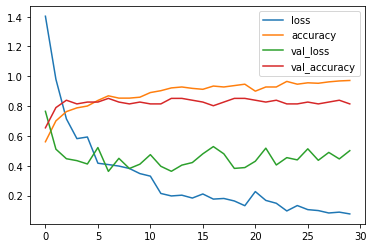

In [150]:
plt.figure(figsize=(12,12))
pd.DataFrame(h.history).plot()
plt.legend(loc='upper right')

In [151]:
#model for classifying box or phone
model.save('box_handy.h5')

/Users/aydin/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
